# Need to change the csv file and update everything 

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticks
import seaborn as sns
import os 
from pmdarima.model_selection import train_test_split


import missingno as miss
import datetime as dt
import statsmodels.tsa.api as tsa

In [2]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)

    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)
            
    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)

    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")

    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index, 
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)

    # set the title and add legend
    ax.set_title(title)
    ax.legend();
    
    return fig, ax

In [3]:
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, 
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

In [4]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

In [5]:
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                 seas_color='black'):
    
    fig, axes = plt.subplots(nrows=2, figsize=figsize)

    
    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')

    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)
    
    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )

    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)
    
    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)



    
    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")

        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m 

        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)
        
        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")

    fig.tight_layout()
    
    return fig

In [6]:
os.listdir('Data')

['Chicago-Crime_2001.csv',
 'Chicago-Crime_2002.csv',
 'Chicago-Crime_2003.csv',
 'Chicago-Crime_2004.csv',
 'Chicago-Crime_2005.csv',
 'Chicago-Crime_2006.csv',
 'Chicago-Crime_2007.csv',
 'Chicago-Crime_2008.csv',
 'Chicago-Crime_2009.csv',
 'Chicago-Crime_2010.csv',
 'Chicago-Crime_2011.csv',
 'Chicago-Crime_2012.csv',
 'Chicago-Crime_2013.csv',
 'Chicago-Crime_2014.csv',
 'Chicago-Crime_2015.csv',
 'Chicago-Crime_2016.csv',
 'Chicago-Crime_2017.csv',
 'Chicago-Crime_2018.csv',
 'Chicago-Crime_2019.csv',
 'Chicago-Crime_2020.csv',
 'Chicago-Crime_2021.csv',
 'Chicago-Crime_2022.csv',
 'README.txt']

In [7]:
# this remomes Readme.txt    [each for each in os.listdir('Data') if each.endswith('csv')]
# then saves as variable 
fps = [each for each in os.listdir('Data') if each.endswith('csv')]

In [8]:
fps

['Chicago-Crime_2001.csv',
 'Chicago-Crime_2002.csv',
 'Chicago-Crime_2003.csv',
 'Chicago-Crime_2004.csv',
 'Chicago-Crime_2005.csv',
 'Chicago-Crime_2006.csv',
 'Chicago-Crime_2007.csv',
 'Chicago-Crime_2008.csv',
 'Chicago-Crime_2009.csv',
 'Chicago-Crime_2010.csv',
 'Chicago-Crime_2011.csv',
 'Chicago-Crime_2012.csv',
 'Chicago-Crime_2013.csv',
 'Chicago-Crime_2014.csv',
 'Chicago-Crime_2015.csv',
 'Chicago-Crime_2016.csv',
 'Chicago-Crime_2017.csv',
 'Chicago-Crime_2018.csv',
 'Chicago-Crime_2019.csv',
 'Chicago-Crime_2020.csv',
 'Chicago-Crime_2021.csv',
 'Chicago-Crime_2022.csv']

In [9]:
# list of data frames and save as variable
df_list = [pd.read_csv("Data/"+ each) for each in fps]

In [10]:
# connecting the dataframes 
df = pd.concat(df_list)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7713109 entries, 0 to 238857
Data columns (total 12 columns):
 #   Column                Dtype  
---  ------                -----  
 0   ID                    int64  
 1   Date                  object 
 2   Primary Type          object 
 3   Description           object 
 4   Location Description  object 
 5   Arrest                bool   
 6   Domestic              bool   
 7   Beat                  int64  
 8   District              float64
 9   Ward                  float64
 10  Latitude              float64
 11  Longitude             float64
dtypes: bool(2), float64(4), int64(2), object(4)
memory usage: 662.0+ MB


In [12]:
df.head(3)

,ID,Date,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude
0,1326041,01/01/2001 01:00:00 AM,BATTERY,SIMPLE,RESIDENCE,False,False,1624,16.0,NaN,41.957850,-87.749185
1,1319931,01/01/2001 01:00:00 PM,BATTERY,SIMPLE,RESIDENCE,False,True,825,8.0,NaN,41.783892,-87.684841
2,1324743,01/01/2001 01:00:00 PM,GAMBLING,ILLEGAL ILL LOTTERY,STREET,True,False,313,3.0,NaN,41.780412,-87.611970


In [13]:
# CORRECT - properly recognizes dates and does not interpret them as seconds
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y %I:%M:%S %p')
df['Date']

0        2001-01-01 01:00:00
1        2001-01-01 13:00:00
2        2001-01-01 13:00:00
3        2001-01-01 01:00:00
4        2001-01-01 01:00:00
                 ...        
238853   2022-12-31 12:50:00
238854   2022-12-31 12:50:00
238855   2022-12-31 00:52:00
238856   2022-12-31 12:52:00
238857   2022-12-31 12:59:00
Name: Date, Length: 7713109, dtype: datetime64[ns]

In [14]:
#Inspect the new index of your dataframe.
df = df.set_index('Date')
df

,ID,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude
Date,,,,,,,,,,,
2001-01-01 01:00:00,1326041,BATTERY,SIMPLE,RESIDENCE,False,False,1624,16.0,NaN,41.957850,-87.749185
2001-01-01 13:00:00,1319931,BATTERY,SIMPLE,RESIDENCE,False,True,825,8.0,NaN,41.783892,-87.684841
2001-01-01 13:00:00,1324743,GAMBLING,ILLEGAL ILL LOTTERY,STREET,True,False,313,3.0,NaN,41.780412,-87.611970
2001-01-01 01:00:00,1310717,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,2424,24.0,NaN,42.012391,-87.678032
2001-01-01 01:00:00,1318099,BATTERY,SIMPLE,RESIDENCE PORCH/HALLWAY,False,True,214,2.0,NaN,41.819538,-87.620020
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 12:50:00,12938029,ASSAULT,SIMPLE,APARTMENT,False,False,1014,10.0,24.0,41.855911,-87.719966
2022-12-31 12:50:00,12937822,ASSAULT,AGGRAVATED - HANDGUN,APARTMENT,False,True,733,7.0,6.0,41.766546,-87.645669
2022-12-31 00:52:00,12937583,BATTERY,SIMPLE,BARBERSHOP,False,False,1135,11.0,28.0,41.868829,-87.686098


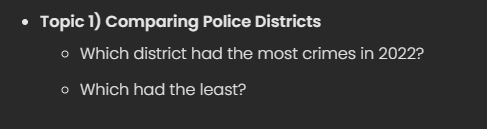

In [15]:
# Primary Type means we dont use nulls 
Q1 = df.loc['2022'].groupby("District").count()['Primary Type']

<Axes: xlabel='District'>

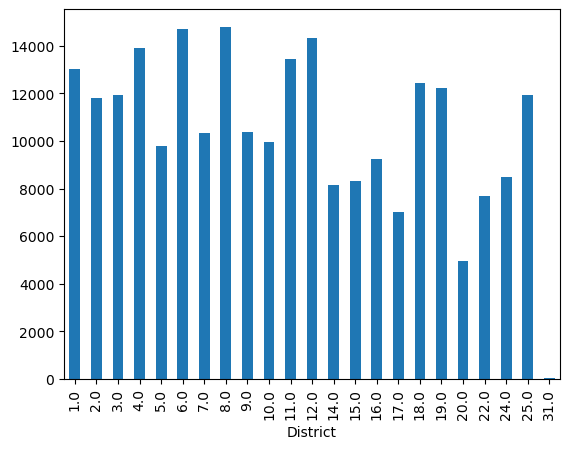

In [16]:
Q1.plot(kind ='bar')

In [17]:
Q1.idxmin()

31.0

In [18]:
Q1.idxmax()

8.0

- The district with the most crimes was district 8 and then the least was district 31

________

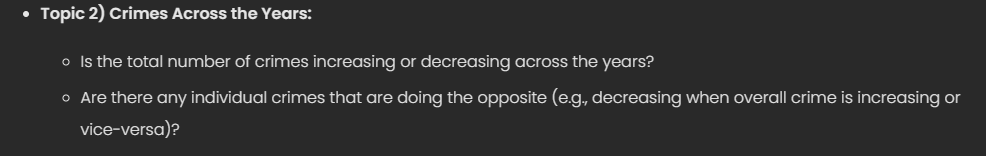

In [19]:
# we are useing resample and not groupby because we are only aggregating over windows of time.  
Q2 = df.resample('Y').size()

<Axes: xlabel='Date'>

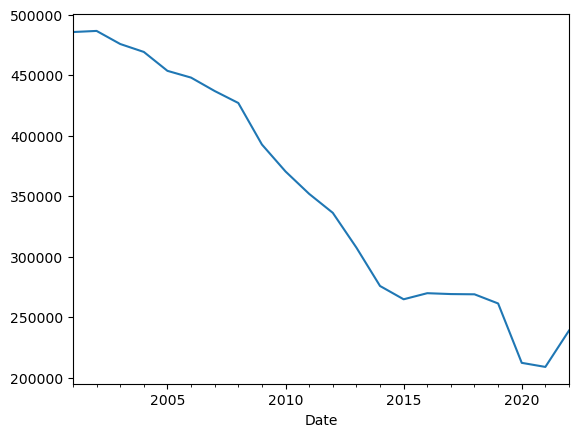

In [20]:
Q2.plot()

- Crimes are decreasing over the years 

In [21]:
# hERE WE ARE GROUPING BY PRIMARY TYPE (AKA CRIMES) AND THEN RESAMPLE BY "Y" TO INCLUDE THE YEARS
Q2b = df.groupby('Primary Type').resample("Y").size()
Q2b

Primary Type       Date      
ARSON              2001-12-31    1011
                   2002-12-31    1032
                   2003-12-31     955
                   2004-12-31     778
                   2005-12-31     691
                                 ... 
WEAPONS VIOLATION  2018-12-31    5456
                   2019-12-31    6339
                   2020-12-31    8432
                   2021-12-31    8980
                   2022-12-31    8766
Length: 723, dtype: int64

array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>], dtype=object)

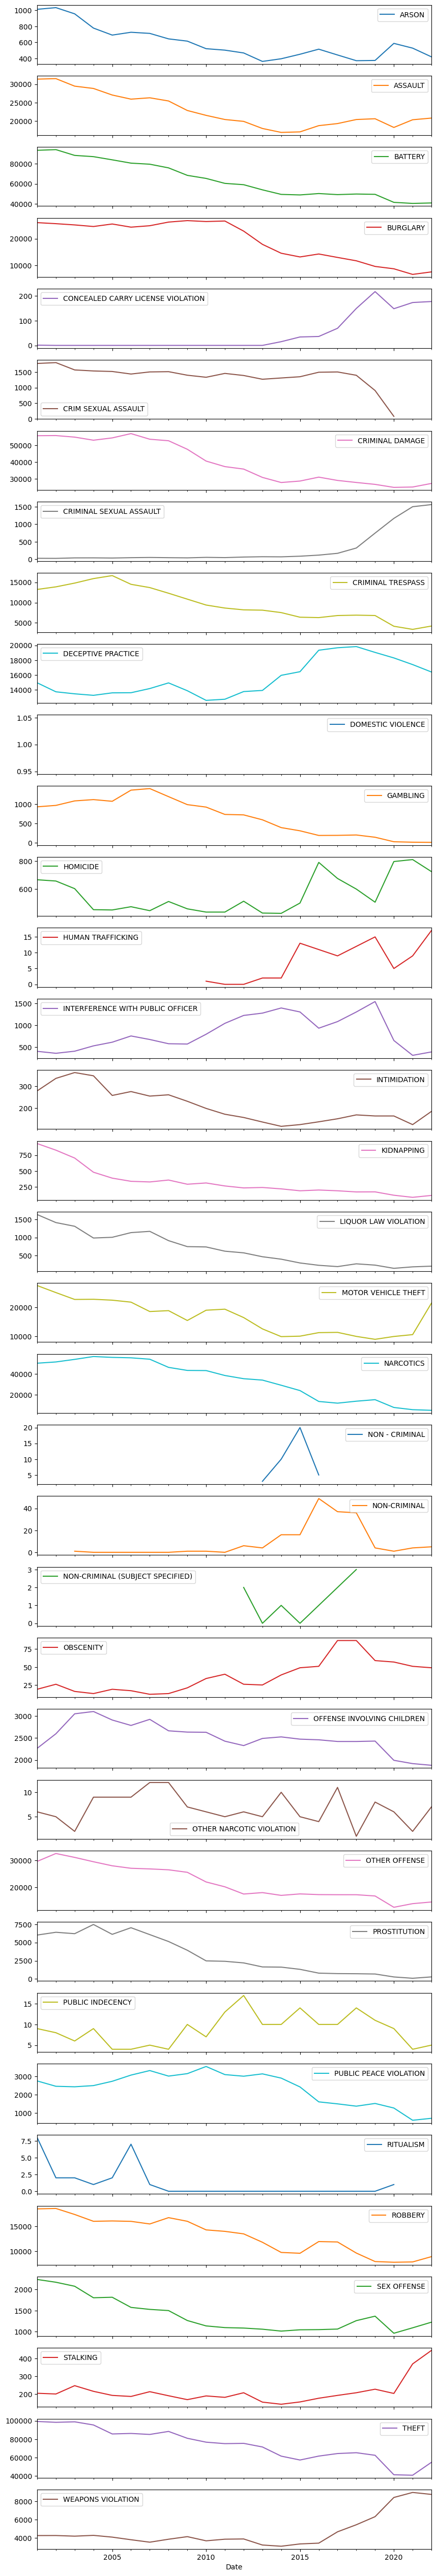

In [22]:
# the T swaps all columns and rows this will help plot better 
Q2b.unstack().T.plot(subplots=True, figsize = (10,65))

 -  

# 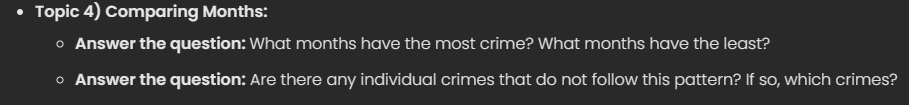

In [23]:
df.index.month

Int64Index([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
            ...
            12, 12, 12, 12, 12, 12, 12, 12, 12, 12],
           dtype='int64', name='Date', length=7713109)

In [24]:
# to visually see what these look like
df.head()

,ID,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude
Date,,,,,,,,,,,
2001-01-01 01:00:00,1326041,BATTERY,SIMPLE,RESIDENCE,False,False,1624,16.0,NaN,41.957850,-87.749185
2001-01-01 13:00:00,1319931,BATTERY,SIMPLE,RESIDENCE,False,True,825,8.0,NaN,41.783892,-87.684841
2001-01-01 13:00:00,1324743,GAMBLING,ILLEGAL ILL LOTTERY,STREET,True,False,313,3.0,NaN,41.780412,-87.611970
2001-01-01 01:00:00,1310717,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,2424,24.0,NaN,42.012391,-87.678032
2001-01-01 01:00:00,1318099,BATTERY,SIMPLE,RESIDENCE PORCH/HALLWAY,False,True,214,2.0,NaN,41.819538,-87.620020


In [25]:
# added month as column
# made sepearate copy of df 
Q3 = df.copy()
Q3['Month'] = df.index.month
Q3.head()

,ID,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude,Month
Date,,,,,,,,,,,,
2001-01-01 01:00:00,1326041,BATTERY,SIMPLE,RESIDENCE,False,False,1624,16.0,NaN,41.957850,-87.749185,1
2001-01-01 13:00:00,1319931,BATTERY,SIMPLE,RESIDENCE,False,True,825,8.0,NaN,41.783892,-87.684841,1
2001-01-01 13:00:00,1324743,GAMBLING,ILLEGAL ILL LOTTERY,STREET,True,False,313,3.0,NaN,41.780412,-87.611970,1
2001-01-01 01:00:00,1310717,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,2424,24.0,NaN,42.012391,-87.678032,1
2001-01-01 01:00:00,1318099,BATTERY,SIMPLE,RESIDENCE PORCH/HALLWAY,False,True,214,2.0,NaN,41.819538,-87.620020,1


<Axes: xlabel='Month'>

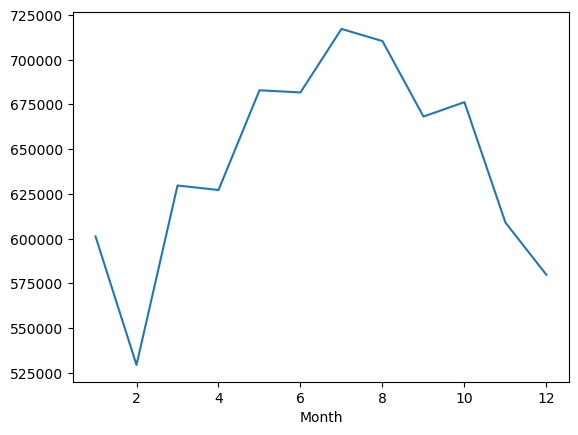

In [26]:
Q3.groupby('Month').size().plot()

### - July and August have the most.   Jan, Feb, and dec have the least crimes. 

In [27]:
# need to use [] when we are grouping by on multiple columns 
Q3b = Q3.groupby(['Primary Type', 'Month']).size()
Q3b


Primary Type       Month
ARSON              1         917
                   2         807
                   3        1111
                   4        1097
                   5        1230
                            ... 
WEAPONS VIOLATION  8        9887
                   9        9435
                   10       9190
                   11       7952
                   12       7401
Length: 415, dtype: int64

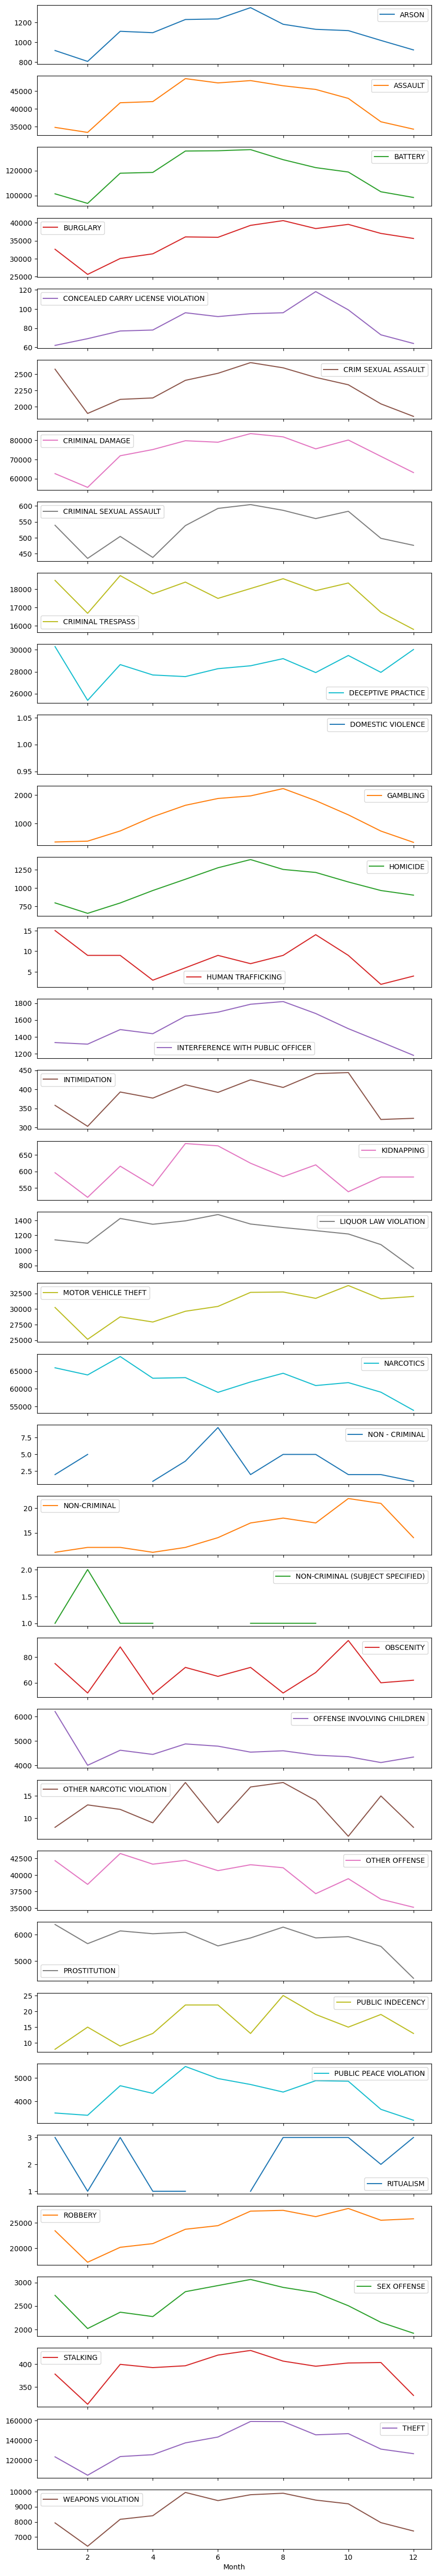

In [28]:
Q3b.unstack().T.plot(subplots = True, figsize = (10,65));

### - Yes there are for the following Crimes (Deceptive Practice, Human Trafficking, Narcotics, Non-Criminal, Obscenity, Offense Involving children, Prostitution, Robbery) 

________________________________

# Project 3- Part 2 (Core)

In [29]:
# ASSAULT on end has to be capital 
Assault = df[df['Primary Type']== 'ASSAULT']

In [30]:
Assault_df = Assault.resample('M').size()

In [31]:
# CHECK FOR NULLS
Assault_df.isna().sum()

0

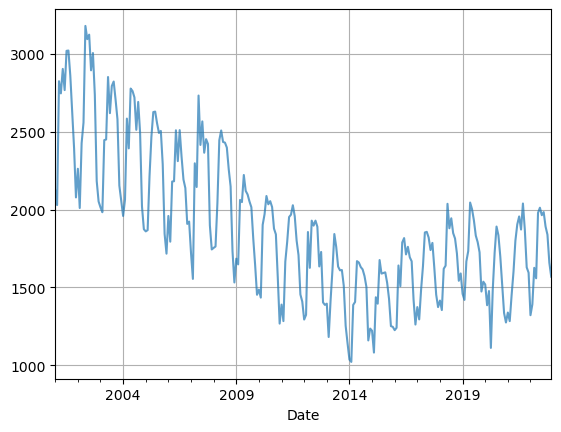

In [32]:
Assault_df.plot(grid=True,alpha=0.7);

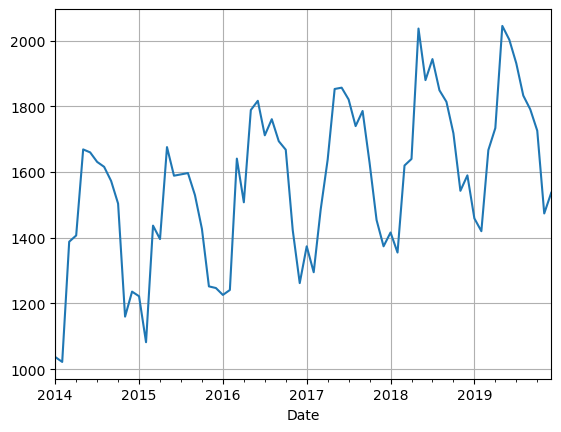

In [33]:
# zoomed in to 5 years to see seasonality better
Assault_df5 = Assault_df.loc['2014':'2019']
Assault_df5.plot(grid=True);

In [34]:
# import the statsmodels time series analysis api module
import statsmodels.tsa.api as tsa
tsa

<module 'statsmodels.tsa.api' from 'C:\\Users\\rdrlr\\anaconda3\\envs\\dojo-env\\lib\\site-packages\\statsmodels\\tsa\\api.py'>

In [35]:
# tsa is library we are getting the funtion from
Assault_decomp = tsa.seasonal_decompose(Assault_df)
Assault_decomp

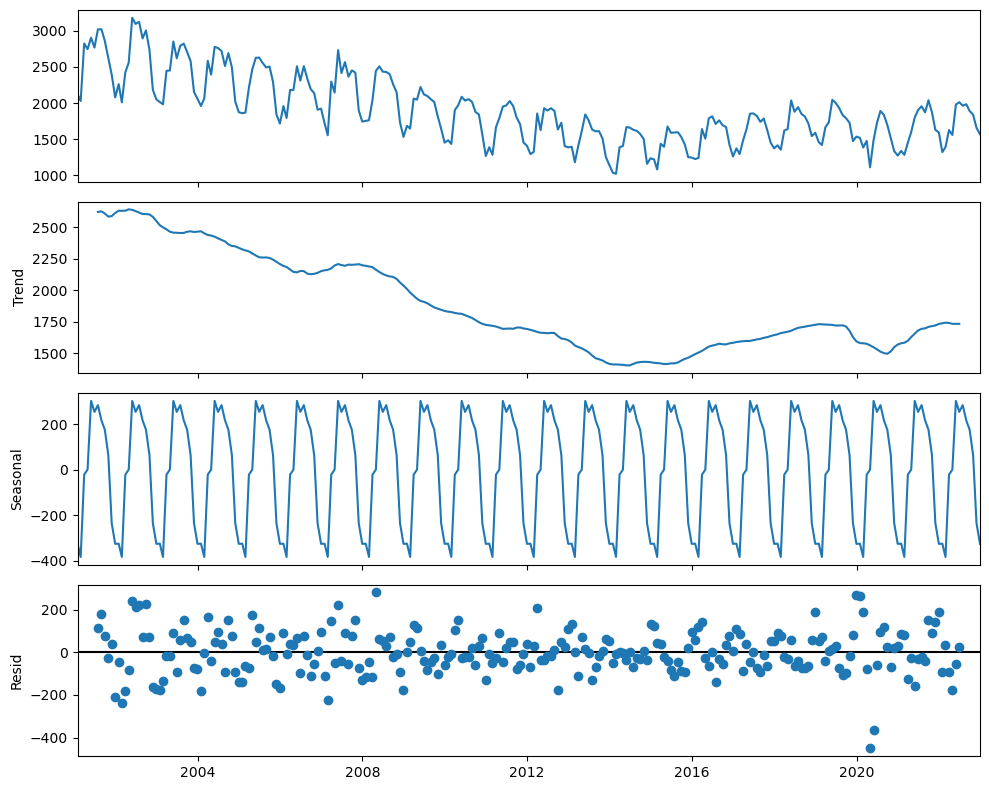

In [36]:
# top is raw data
fig = Assault_decomp.plot()
fig.set_size_inches(10,8)
fig.tight_layout()

In [37]:
# this will bring back seasonal (bring back numbers that make the component)
Assault_seasonal = Assault_decomp.seasonal
Assault_seasonal 

Date
2001-01-31   -325.265542
2001-02-28   -383.400463
2001-03-31    -22.374669
2001-04-30      0.145172
2001-05-31    301.488426
                 ...    
2022-08-31    216.012235
2022-09-30    175.129299
2022-10-31     63.194775
2022-11-30   -235.235780
2022-12-31   -325.999669
Freq: M, Name: seasonal, Length: 264, dtype: float64

In [38]:
Assault_seasonal .max()

301.4884259259259

In [39]:
Assault_seasonal .min()

-383.40046296296293

In [40]:
magnitude = Assault_seasonal.max() - Assault_seasonal.min()
magnitude

684.8888888888889

- During peak weeks we see almost 700 more cases per month than we do the low months. 

In [41]:
# How big is the seasonal component
seasonal_delta = Assault_seasonal.max() - Assault_seasonal.min()

# How big is the seasonal component relative to the time series?
print(f"The seasonal component is {seasonal_delta} which is ~{seasonal_delta/(Assault_df.max()-Assault_df.min()) * 100 :.2f}% of the variation in time series.")



The seasonal component is 684.8888888888889 which is ~31.75% of the variation in time series.


In [42]:
from pmdarima.arima.utils import ndiffs, nsdiffs

In [43]:
d = ndiffs(Assault_df)
print(f'd is {d}')

d is 1


In [44]:
# # Testing the raw data for stationarity
get_adfuller_results(Assault_df)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-1.836624,15,248,0.362437,0.05,False


In [45]:
Assault_df.head()

Date
2001-01-31    2123
2001-02-28    2029
2001-03-31    2824
2001-04-30    2746
2001-05-31    2903
Freq: M, dtype: int64

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-3.936162,14,248,0.001784,0.05,True


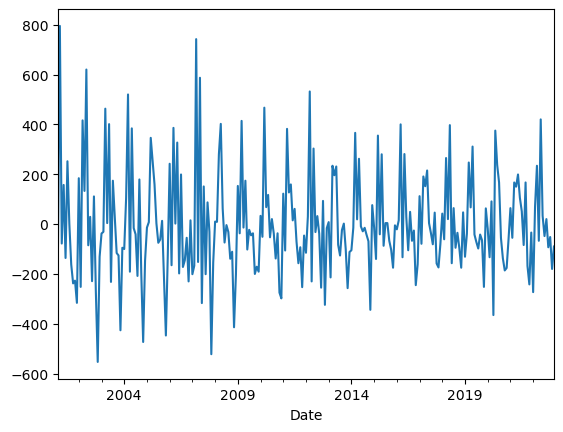

In [46]:
# Differencing the data once. need to do nulls again . makes stationary enought to model on
ts_diff = Assault_df.diff().dropna()
ts_diff.plot()
# Checking for stationarity
get_adfuller_results(ts_diff)

# we can see its stationary True 

In [47]:
# this tell us we dont need to difference at seasonal level 
# if it was a 1 we need to difference once 
D = nsdiffs(Assault_df, m=12 )
print(f'D is {D}')

D is 0


We know m= 12, D= 0 and d=1  , missing P, Q, p, q

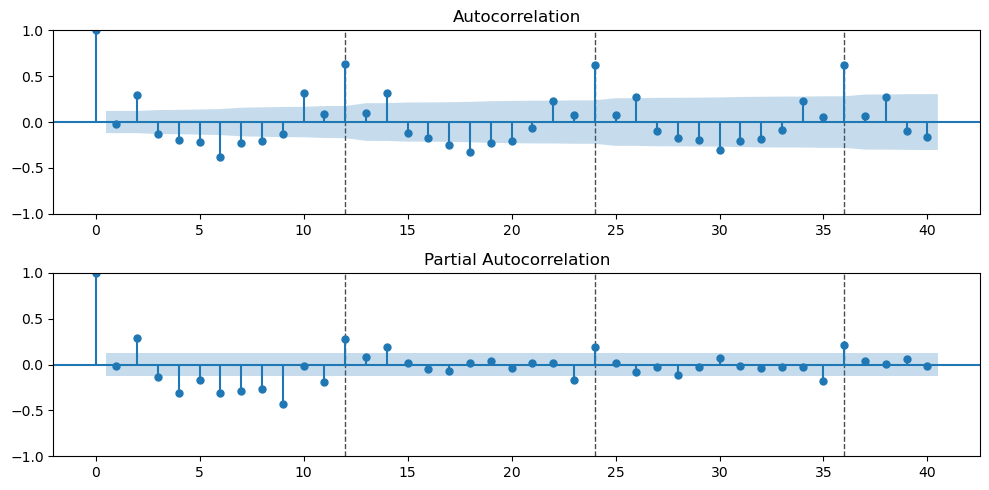

In [48]:
# look at dotted lines show at sesaonal level look at these to choose P and Q 
# lower case p and q need to look at whole plot 
# because there is no clear patters on acf and pcf plots will use P,Q,p,q set to 1 on next steps
plot_acf_pacf(ts_diff, m=12, annotate_seas=True);

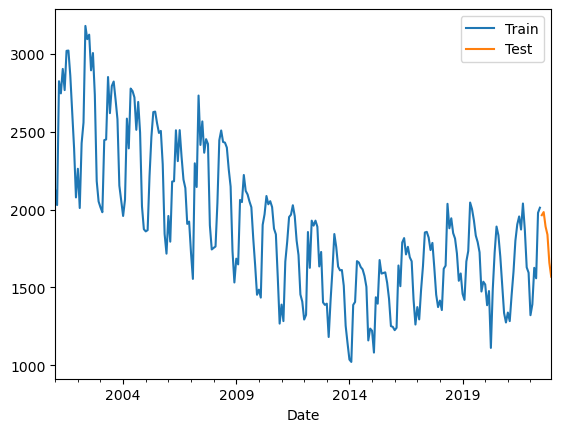

In [55]:
# Calculating number of test lags- use 6 because 6 months... if daily and want to forecast one week we would use 7
n_test_lags = 6

# Modeling to predict 6 months into the future
train, test = train_test_split(Assault_df, test_size=n_test_lags)
ax = train.plot(label='Train')
test.plot(ax=ax, label='Test')
ax.legend();

In [57]:
p = 1 
q = 1
d = 1
P = 1
D = 0
Q = 1
m = 12 
model1 = tsa.ARIMA(train, order=(p,d,q), seasonal_order=(P,D,Q, m)).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                                y   No. Observations:                  258
Model:             ARIMA(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood               -1609.047
Date:                          Thu, 18 Jan 2024   AIC                           3228.093
Time:                                  17:48:21   BIC                           3245.839
Sample:                              01-31-2001   HQIC                          3235.230
                                   - 06-30-2022                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9065      0.041     22.068      0.000       0.826       0.987
ma.L1         -0.9995      0.020    -48.780      0.000      -1.040      -0.959
ar.S.L12       0.9908      0.006    161.545      0.000       0.979       1.003
ma.S.L12      -0.7781      0.069    -11.196      0.000      -0.914      -0.642
sigma2      1.502e+04   1335.115     11.247      0.000    1.24e+04    1.76e+04
===================================================================================
Ljung-Box (L1) (Q):                  18.57   Jarque-Bera (JB):                21.66
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.49   Skew:                             0.30
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 46.958
- MSE = 2,561.043
- RMSE = 50.607
- R^2 = 0.892
- MAPE = 2.62%


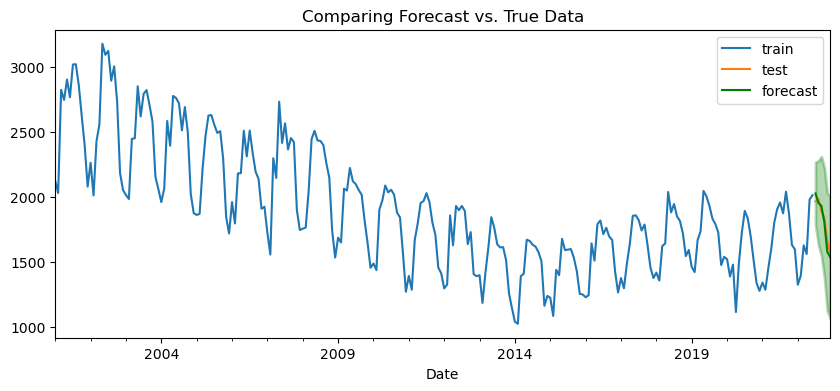

In [64]:
# Obtain forecast as a dataframe with confidence intervals
forecast_df = model1.get_forecast(steps=len(test)).summary_frame()
# Call the custom function to plot the forecasts with confidence intervals and true values
plot_forecast(train, test, forecast_df);
# Obtain metrics
regression_metrics_ts(test, forecast_df['mean'])

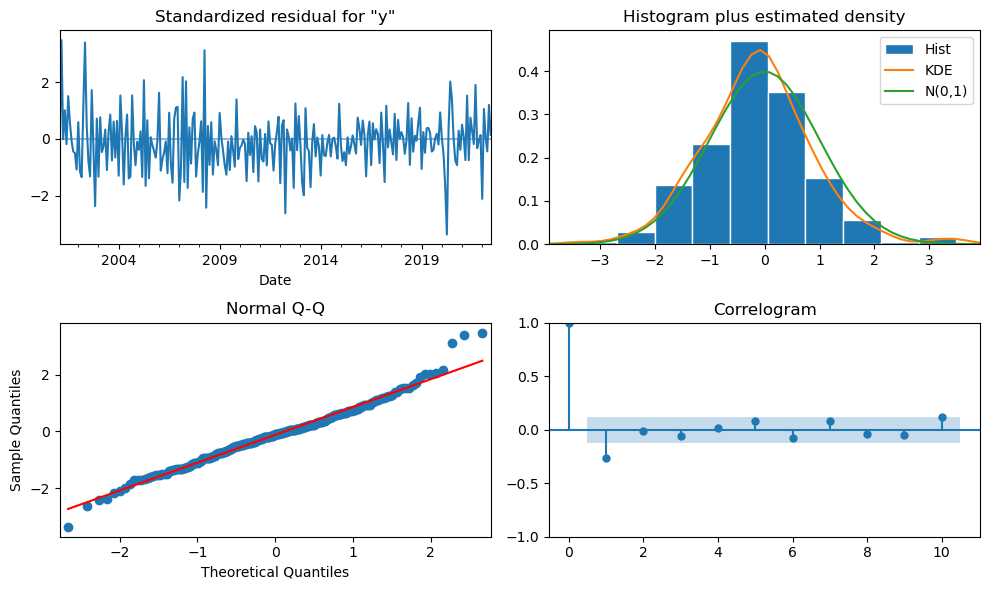

In [58]:
# NEED TO LOOK AT CORE ARIMA WITH THIS TO HELP 
# Obtain diagnostic plots
fig = model1.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

In [66]:
import pmdarima as pm

# Default auto_arima will select model based on AIC score
auto_model = pm.auto_arima(
    train,
    seasonal=True,  
    m=12,
    trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=1.29 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3483.860, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3318.021, Time=0.35 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3405.065, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3481.861, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=3485.758, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=0.74 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.50 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=3404.125, Time=0.26 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=1.93 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=3337.645, Time=0.15 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=3313.233, Time=0.44 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=3462.085, Time=0.23 sec
 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=0.94 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=3

In [60]:
# the auto_arima will store our best nonseasonal and seasonal orders separtely
print(auto_model.order)
print(auto_model.seasonal_order)

(4, 1, 0)
(2, 0, 2, 12)


In [61]:
# Obtain summary of the best model from auto_arima
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  258
Model:             SARIMAX(4, 1, 0)x(2, 0, [1, 2], 12)   Log Likelihood               -1586.057
Date:                                 Thu, 18 Jan 2024   AIC                           3192.113
Time:                                         17:51:07   BIC                           3227.604
Sample:                                     01-31-2001   HQIC                          3206.386
                                          - 06-30-2022                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0089      0.523      0.017      0.986      -1.016       1.034
ar.L1         -0.4435      0.059     -7.580      0.000      -0.558      -0.329
ar.L2         -0.2795      0.066     -4.246      0.000      -0.409      -0.150
ar.L3         -0.2493      0.063     -3.950      0.000      -0.373      -0.126
ar.L4         -0.1597      0.063     -2.525      0.012      -0.284      -0.036
ar.S.L12       1.3951      0.212      6.593      0.000       0.980       1.810
ar.S.L24      -0.4026      0.210     -1.915      0.056      -0.815       0.009
ma.S.L12      -1.3303      0.194     -6.844      0.000      -1.711      -0.949
ma.S.L24       0.5551      0.149      3.726      0.000       0.263       0.847
sigma2      1.162e+04    949.141     12.247      0.000    9763.808    1.35e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                23.81
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.60   Skew:                            -0.13
Prob(H) (two-sided):                  0.02   Kurtosis:                         4.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

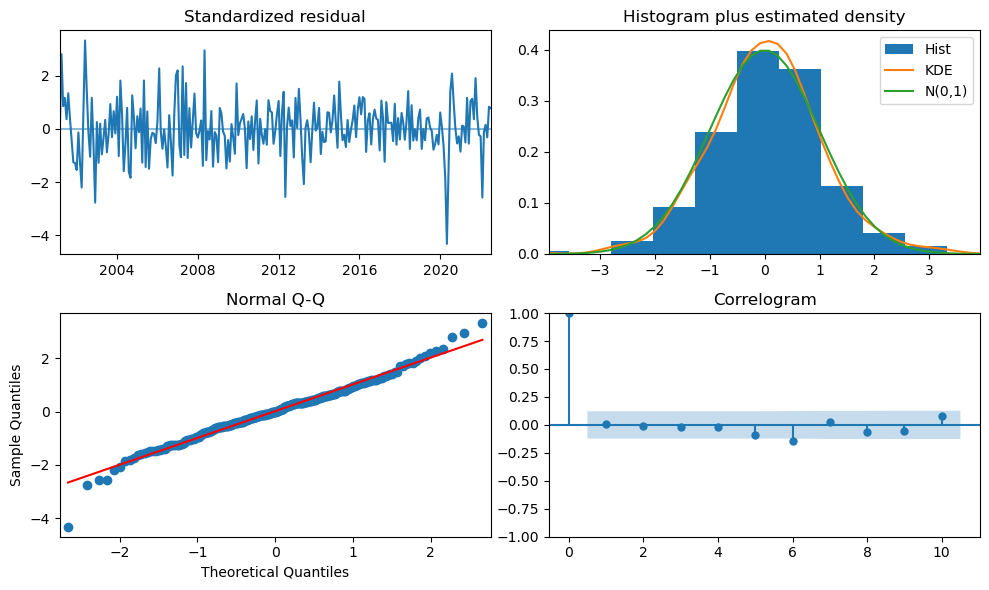

In [62]:
# Obtain diagnostic plots
fig = auto_model.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()



C:\Users\rdrlr\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 39.060
- MSE = 2,143.921
- RMSE = 46.302
- R^2 = 0.909
- MAPE = 2.19%


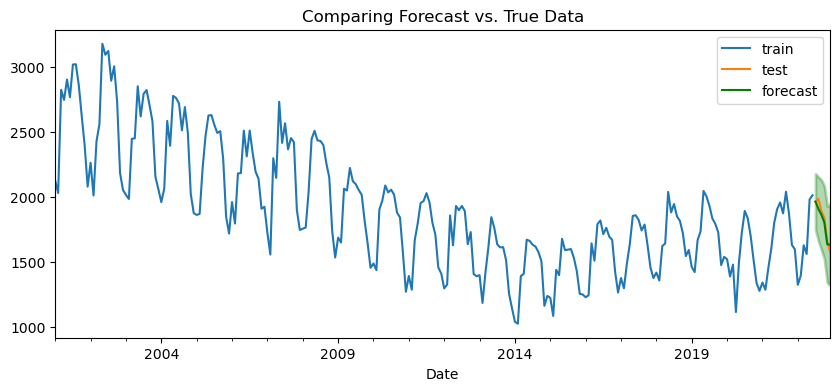

In [68]:
# Use auto_arima parameters to fit an ARIMA
auto_model2 = tsa.ARIMA(
    train, order=auto_model.order, seasonal_order=auto_model.seasonal_order
).fit()


# Obtain forecast as a dataframe with confidence intervals
forecast_df = auto_model2.get_forecast(steps=len(test)).summary_frame()
# Call the custom function to plot the forecasts with confidence intervals and true values
plot_forecast(train, test, forecast_df);
# Obtain metrics
regression_metrics_ts(test, forecast_df['mean'])



In [69]:
final_model = tsa.ARIMA(
    Assault_df, order=auto_model.order, seasonal_order=auto_model.seasonal_order
).fit()

C:\Users\rdrlr\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [70]:
final_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                       
=============================================================================================
Dep. Variable:                                     y   No. Observations:                  264
Model:             ARIMA(4, 1, 0)x(2, 0, [1, 2], 12)   Log Likelihood               -1624.617
Date:                               Thu, 18 Jan 2024   AIC                           3267.234
Time:                                       18:47:52   BIC                           3299.384
Sample:                                   01-31-2001   HQIC                          3280.154
                                        - 12-31-2022                                         
Covariance Type:                                 opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4508      0.059     -7.669      0.000      -0.566      -0.336
ar.L2         -0.2937      0.068     -4.339      0.000      -0.426      -0.161
ar.L3         -0.2596      0.064     -4.041      0.000      -0.385      -0.134
ar.L4         -0.1693      0.067     -2.537      0.011      -0.300      -0.038
ar.S.L12       1.8432      0.241      7.648      0.000       1.371       2.316
ar.S.L24      -0.8445      0.240     -3.520      0.000      -1.315      -0.374
ma.S.L12      -1.6729      0.226     -7.405      0.000      -2.116      -1.230
ma.S.L24       0.7337      0.160      4.589      0.000       0.420       1.047
sigma2      1.203e+04   1013.686     11.871      0.000       1e+04     1.4e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                31.32
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.59   Skew:                            -0.21
Prob(H) (two-sided):                  0.02   Kurtosis:                         4.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# Obtain forecast as a dataframe with confidence intervals
forecast_df = sarima.get_forecast(steps=len(test)).summary_frame()
# Call the custom function to plot the forecasts with confidence intervals and true values
plot_forecast(train, test, forecast_df);
# Obtain metrics
regression_metrics_ts(test, forecast_df['mean'])